# Tache 9

Ludovic Delferiere 81232000

# Initialisation du BaF2 et import 

In [18]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import integrate
mp_key = "hWWmIDodjhkgKVHj88m318vKs3nGtcQp"
mp_id = "mp-1029"
with MPRester(mp_key) as m:
    #récupération de la structure
    struct = m.get_structure_by_material_id(mp_id)
    #récupération de la densité d'états de phonons
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# calcul des températures de Debye et d'Einstein telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique

In [19]:
#Constantes diverses
temperatures = np.arange(0,1000,5)
R = 8.314
Nat = len(struct)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*Nat*R)


In [20]:
#einstein
def einstein(e, T):
    cv= ((e/T)**2) * np.exp(e/T) / ((np.exp(e/T) - 1) ** 2)
    return cv

erreur_minim = 0
t_einstein = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = einstein(i, temperatures[j])
        a = (cv_pred - ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_minim_e = erreur
    if erreur < erreur_minim_e:
        erreur_minim_e = erreur
        t_einstein = i
print("Température d'Einstein :",t_einstein,"K")
cv_einstein =[temperatures[0]]
for i in range(1,200):
    cv_einstein.append(einstein(t_einstein, temperatures[i]))



Température d'Einstein : 251 K


In [21]:
#debye
def f(x):
    return (x**4) * np.exp(x) / ((np.exp(x) - 1)**2)
def modele_debye(d, T):
    cv = 3*((T/d)**3)*integrate.quad(f, 0, d/T)[0]
    return cv
erreur_minin = 0
t_debye = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv = modele_debye(i, temperatures[j])
        a = (cv - ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_minim = erreur
    if erreur < erreur_minim:
        erreur_minim = erreur
        t_debye = i
print("Température de Debye :",t_debye,"K")
cv_debye=[temperatures[0]]
for i in range(1,200):
    cv_debye.append(modele_debye(t_debye, temperatures[i]))

Température de Debye : 339 K


# Représentation des 3 courbes de chaleurs spécifiques

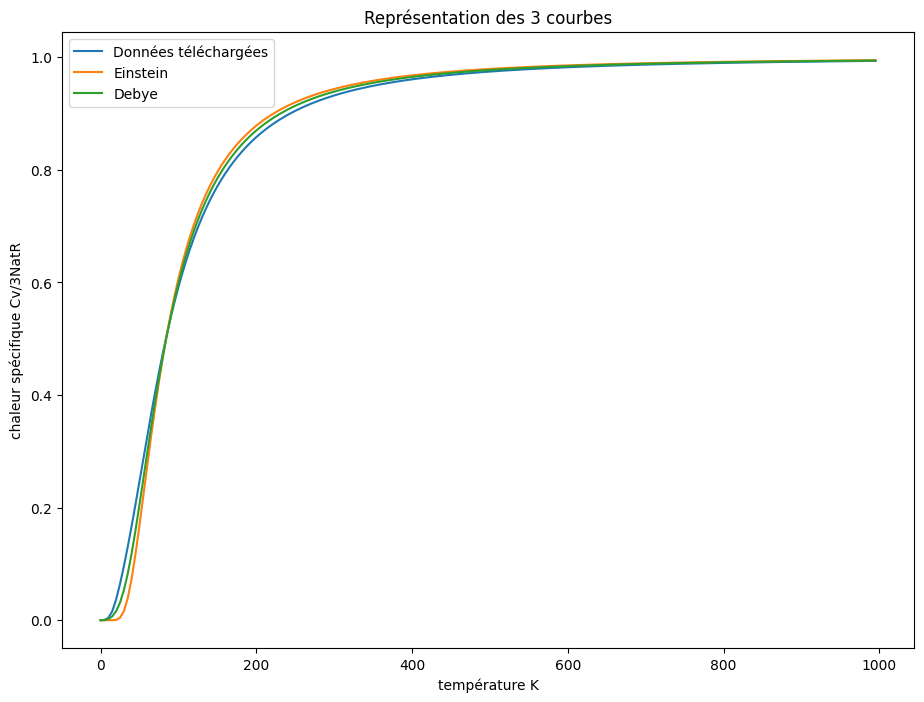

In [22]:
#représentation de toutes les courbes
plt.figure(figsize=(11, 8))
plt.plot(temperatures, ph_cv, label='Données téléchargées')
plt.plot(temperatures, cv_einstein, label="Einstein")
plt.plot(temperatures, cv_debye, label="Debye")
plt.title('Représentation des 3 courbes')
plt.xlabel('température K')
plt.ylabel('Cv/3NatR')
plt.legend()
plt.show()

# Représentation des 3 densités d'états de phonons correspondantes

La fréquence d'Einstein est de  5.229989581682891 THz.

la fréquence de Debye est de  7.063611427053786 THz.


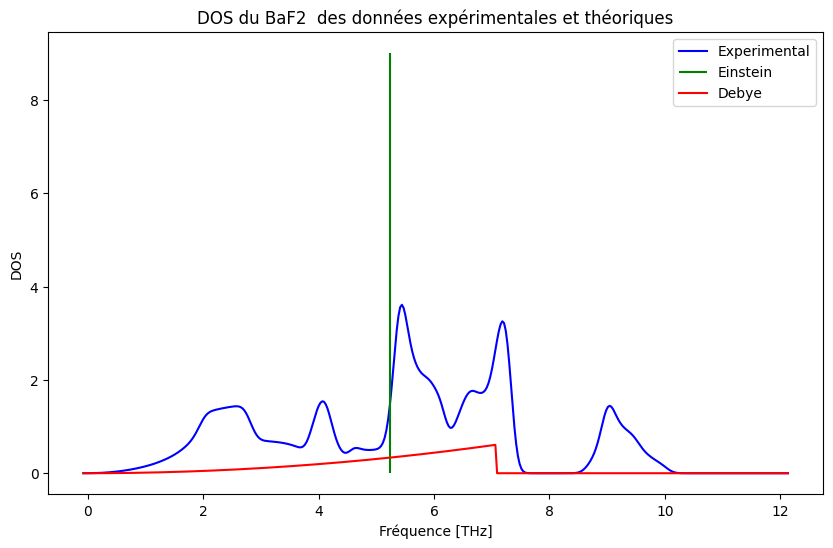

In [23]:
kb = 1.38064852e-23 
h = 6.62607015e-34 
f = ph_dos.frequencies
dos = ph_dos.densities
#frequence d'Einstein et de Debye en THz
f_Einstein = (t_einstein * kb)*10**(-12)/h 
f_Debye = (t_debye * kb)*10**(-12)/h
print("La fréquence d'Einstein est de ",f_Einstein,"THz.\n")
print("la fréquence de Debye est de ",f_Debye,"THz.")
g_D = np.zeros(len(f))
for i in range(len(f)):
    if f[i]<f_D:
        g_D[i] = (9*Nat*(f[i])**2)/((2*np.pi)*(f_D)**3)
plt.figure(figsize=(10, 6))
plt.plot(f, dos,color='b', label="Experimental")
plt.vlines(f_Einstein,0,3*Nat, color='g', label="Einstein")
plt.plot(f, g_D, color="r", label="Debye")
plt.xlabel('Fréquence [THz]')
plt.ylabel('DOS')
plt.title("DOS du BaF2  des données expérimentales et théoriques")
plt.legend()
plt.show()